In [ ]:
!python --version

Python 3.7.12


In [ ]:
'''기술 통계 및 ARIMA 모델링. 기술 통계에는 해당 시계열의 기본을 보여주는 목적이 있습니다.
추세, 순환 및 확률과 같은 프로세스. 데이터는 2019년 이전과 2019년 이후의 두 하위 집합으로 나뉩니다.
기본 프로세스에 변경 사항이 있을 것으로 예상'''


try:
    import numpy as np
    import pandas as pd
    import sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    
except:
    raise ImportError("One of required package is not installed")
    
def normalize(data):  # Normalization MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    index = data.index
    columns = data.columns

    scaler = MinMaxScaler()
    fit = scaler.fit_transform(data)
    dataframe = pd.DataFrame(fit, index = index, columns = columns)
    return dataframe

class TimeSeriesTests(object): # 타임시리즈 테스트 클래스
    def __init__(self, data):
        self.data = data
    
    def plot(self):
        self.data.plot(figsize = (16, 6), style = "+-")
        
    def check(self, ignore = False):
        if isinstance(self.data, pd.DataFrame) == False:
            print("Passed data is not dataframe format. Coverting into dataframe")
            data = pd.DataFrame(self.data)
        
        if (self.data.isna().sum() > 0).any() == True:
            raise ValueError("data contains nan values")
        else:
            return self.data
        
        if ignore == True:
            data = data.fillna(method = "bfill")
            data = data.fillna(method = "pad")
            data.dropna(inplace = True)
            return data      
    
    def normaltest(self):
        from scipy.stats import jarque_bera
        data = self.check()
        columns = data.columns
        for i in range(data.shape[1]):
            stats, p_values = jarque_bera(data.iloc[:, i])
            print(f"Jarque_beta statistics for : {columns[i], stats}, p_values: {p_values}")
            print("Data is normally distributed") \
                if p_values < 0.05 else print("Data is not normallly distributed")
        
    def Adfuller(self, regression = None):
        from arch.unitroot import ADF
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        
        if regression is not None:
            for i in range(data.shape[1]):
                print("ADF test for", self.columns[i])
                print(ADF(data.iloc[:, i], trend = self.regression))
        else:
            for i in range(data.shape[1]):
                print("ADF test for", self.columns[i])
                print(ADF(data.iloc[:, i], trend = "n"))
            
    def KPSS(self, regression = None):    
        from statsmodels.tsa.stattools import kpss
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        if regression is not None:
            for i in range(data.shape[1]):
                t_stat, p_value, _, critical_values = \
                kpss(data.iloc[:, i].values, nlags='auto', regression = "ct")
                print(f'ADF Statistic: {t_stat:.2f} for', data.columns[i])
                
                for key, value in critical_values.items():
                    print('Critial Values:')
                    print(f'   {key}, {value:.2f}')
                    print(f'\np-value: {p_value:.2f}')
                    print("Stationary") if p_value > 0.05 else print("Non-Stationary")
        
        else:
            for i in range(data.shape[1]):
                t_stat, p_value, _, critical_values = \
                kpss(data.iloc[:, i].values, nlags='auto', regression = "c")
                print(f'ADF Statistic: {t_stat:.2f} for', data.columns[i])
                
                for key, value in critical_values.items():
                    print('Critial Values:')
                    print(f'   {key}, {value:.2f}')
                    print(f'\np-value: {p_value:.2f}')
                    print("Stationary") if p_value > 0.05 else print("Non-Stationary")
          
    def Cointegration(self, regression = None):
        from arch.unitroot import engle_granger
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        if regression is not None:
            for i in range(data.shape[1] - 1):
                print("Conintegration Test for", data.columns[0], "And", data.columns[i + 1], "\n")
                print(engle_granger(data.iloc[:, 0], data.iloc[:, i + 1], trend = regression))
        else:
            for i in range(data.shape[1] - 1):
                print("Conintegration Test for", data.columns[0], "And", data.columns[i + 1], "\n")
                print(engle_granger(data.iloc[:, 0], data.iloc[:, i + 1], trend = "n"))

    def Seasonal(self, model, period): # 계절성 빼기
        from statsmodels.tsa.seasonal import seasonal_decompose
        data = self.check()
        index = data.index
        self.model = str(model)
        self.period = int(period)
        if (data.shape[1] >= 1):
            print("Only First Column will be passed")
        sd = seasonal_decompose(data.iloc[:, 0], model = self.model, period = self.period)
        sd.plot()
        
        residuals = sd.resid
        seasonal = sd.seasonal
        trend = sd.trend
        dataframe = pd.DataFrame(pd.concat([residuals, seasonal, trend], axis = 1), \
                                 index = index, columns = ["residuals", "seasonal", "trend"])
        return dataframe

# Time Series model classes

class TimeSeries(TimeSeriesTests):
    def __init__(self, data):
        self.data = data
        pass
    
    def CMAX(self, windows):
        X = list()
        data = pd.DataFrame(self.data)
        data = self.data.fillna(method = "bfill")
        data = self.data.fillna(method = "pad")
        index = self.data.index
        columns = self.data.columns
        values = self.data.values
        for i in range(len(values)):
            cmax = (1 - values[i]) / np.max(values[i : i + windows])
            X.append(cmax)
        dataframe = pd.DataFrame(X, index = index, columns = columns)
        return dataframe
        
    def ARIMA(self, seasonal = False): # ARIMA model
        import pmdarima
        self.data = self.data.fillna(method = "bfill")
        self.data = self.data.fillna(method = "pad")
        order = pmdarima.auto_arima(self.data)
        print(order.summary())
        if seasonal is True:
            self.data = self.data.fillna(method = "bfill")
            self.data = self.data.fillna(method = "pad")
            if pd.infer_freq(self.data.index, warn = True) == 'QS-OCT':
                self.seasonal = 4
                order = pmdarima.auto_arima(self.data, seasonal = True, m = self.seasonal)
                print(order)
            if pd.infer_freq(self.data.index, warn = True) == "MS":
                self.seasonal = 12
                order = pmdarima.auto_arima(self.data, seasonal = True, m = self.seasonal)
                print(order)
            if pd.infer_freq(self.data.index, warn = True) == "B":
                order = pmdarima.auto_arima(self.data, seasonal= False)
                print(order)
                pass
        pass
    
    def VAR(self, irf = False, fevd = False):
        from statsmodels.tsa.api import VAR
        from statsmodels.stats.stattools import durbin_watson
        self.data = self.data.fillna(method = "bfill")
        self.data = self.data.fillna(method = "pad")
        model = VAR(self.data)
        order = model.select_order(maxlags = 12)
        fitted = model.fit(order.aic)
        print(fitted.summary())
        residual_test = durbin_watson(fitted.resid)
        for col, val in zip(self.data.columns, residual_test):
            print("Residual test, you are safe if beween 1.5 and 2.5")
            print(col, ":", round(val, 2))
        if irf is True:
            irf = fitted.irf(24)
            for i in range(self.data.shape[1]):
                irf.plot(impulse = str(self.data.columns[i]))
        if fevd is True:
            fevd = fitted.fevd(6)
            fevd.summary()
            fitted.fevd(24).plot()
        pass
    
def ImportData():
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df.csv", 
                     index_col = "contract_date")
    return df

df = ImportData()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Statistic Descriptives 통계적 설명
'''df1 데이터셋은 2014~2018년, df2 데이터셋은 2019~2020년'''

df1 = df[df.index <= "2018-12-30"]
df2 = df[df.index >= "2019-01-01"]

In [ ]:
#2014~2018
df1.describe()

,seoul,daejeon,daegu
count,261.000000,261.000000,261.000000
mean,2104.965517,244.022989,276.839080
std,443.257421,53.523175,49.446678
min,173.000000,24.000000,60.000000
25%,1848.000000,208.000000,248.000000
50%,2046.000000,237.000000,276.000000
75%,2350.000000,277.000000,309.000000
max,4059.000000,394.000000,429.000000


In [ ]:
#2019~2020
df2.describe()

,seoul,daejeon,daegu
count,105.000000,105.000000,105.000000
mean,2192.733333,282.352381,316.676190
std,475.065183,60.079272,57.336305
min,744.000000,81.000000,134.000000
25%,1898.000000,245.000000,283.000000
50%,2165.000000,275.000000,319.000000
75%,2484.000000,317.000000,350.000000
max,3364.000000,423.000000,440.000000


두 데이터셋의 차이점은 2018년 이후 시그마(표준편차)가 더 높고 평균적으로 거래량이 약간 증가했다는 것 뿐이다. 이외에도 최소 거래량은 급증했지만 최대 거래량은 감소했습니다.

In [ ]:
# Skewness, Kurtosis check 왜도,첨도 확인
from scipy.stats import skew, kurtosis

for i in range(df1.shape[1]):
    print("Skewness_df1" + df1.columns[i], skew(df1.iloc[:, i]))
    
for i in range(df2.shape[1]):
    print("Skewness_df2" + df2.columns[i], skew(df2.iloc[:, i]))
    
for i in range(df1.shape[1]):
    print("Kurtosis_df1" + df1.columns[i], kurtosis(df1.iloc[:, i]))
    
for i in range(df2.shape[1]):
    print("Kurtosis_df2" + df2.columns[i], kurtosis(df2.iloc[:, i]))

Skewness_df1seoul 0.1777172998135754
Skewness_df1daejeon 0.12915722190935053
Skewness_df1daegu -0.28603971625339625
Skewness_df2seoul -0.259763967867906
Skewness_df2daejeon -0.06176125525336367
Skewness_df2daegu -0.5020849238720703
Kurtosis_df1seoul 2.6388061377027494
Kurtosis_df1daejeon 1.1615788215013607
Kurtosis_df1daegu 1.520190825629701
Kurtosis_df2seoul 0.43510349707625506
Kurtosis_df2daejeon 0.9667703447039169
Kurtosis_df2daegu 0.760183868614829


서울은 양의 왜도(오른쪽으로 치우짐)를 보였으나 2018년 이후 음의 왜도(왼쪽으로 치우짐)를 보이고 있다.
이것이 의미하는바는 이전년도와 비교해보면 거래가 증가했음을 의미한다.
서울 첨도는 극값이 많은 플랫분포를 형성했지만, 2018년 이후에는 정규 분포에 가깝습니다.
2018년 이후로는 거래량이 덜 극값을 가지는것을 말한다.
https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

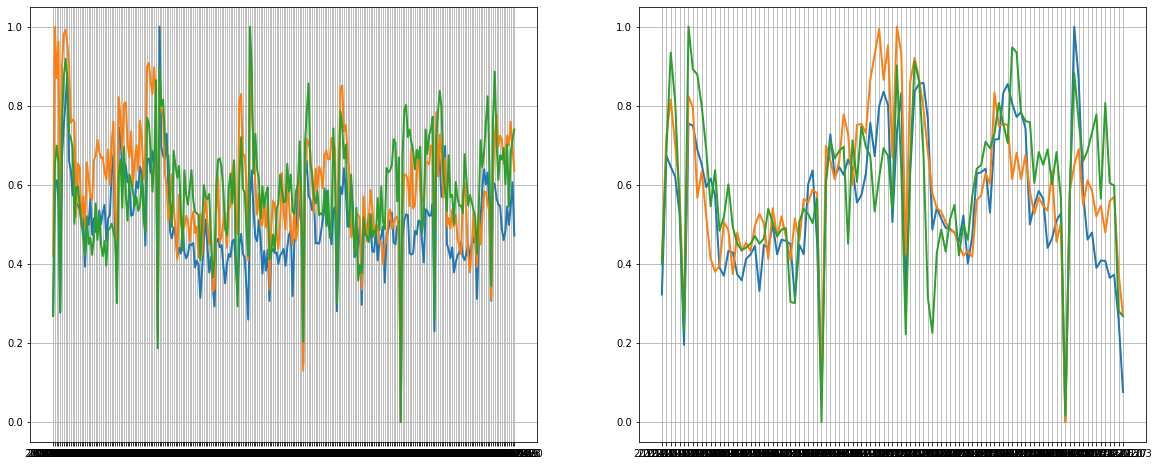

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화 - minmaxscaler 표준화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(normalize(df1))
ax2.plot(normalize(df2))

왼쪽 플롯은 2018년 이전이고 거래량이 도시들간의 상관관계 있는 것으로 보이며, 오른쪽 플롯 2018년 이후도 상관관계가 있는것으로 보입니다.
1차 임대차 3법이 2019.07에 통과된 이후 가구의 계약이 연장될 가능성이 있어 거래 건수가 증가할 것으로 예상됩니다.
1차 임대차 3법은 2018년 이전 계약자에게 유효하기에 2019년에도 효력이 발생합니다.(2017년에 계약을 체결한 사람)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

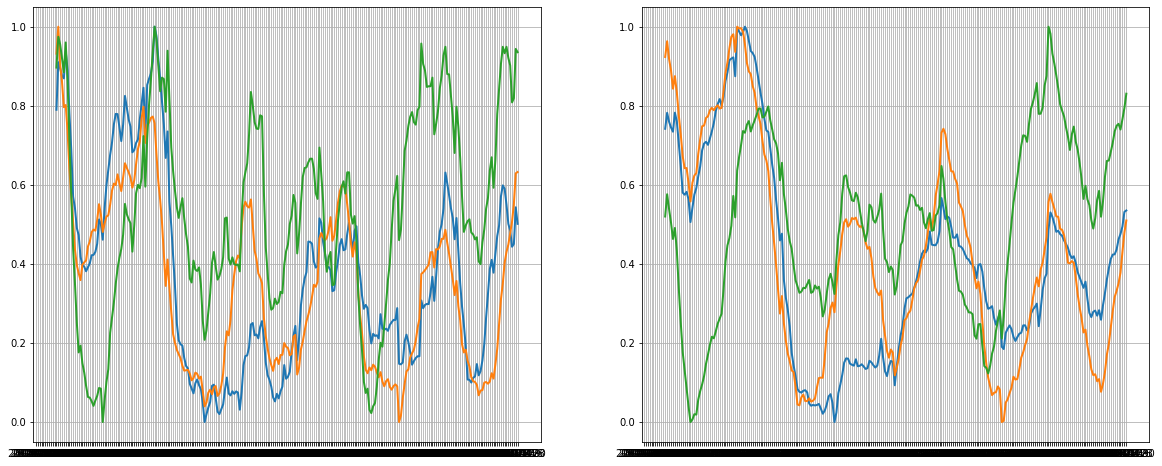

In [ ]:
# 3달 이동평균선, 6달 이동평균선 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(normalize(df1.rolling(12).mean()))
ax2.plot(normalize(df1.rolling(24).mean()))
# ax3.plot(normalize(df2.rolling(12).mean()))
# ax4.plot(normalize(df2.rolling(24).mean()))

사이클 요소를 확인하였지만, 규칙적이지 않은 것 같고 변동성도 큰 것으로 보입니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

[Text(0.5, 1.0, '2020')]

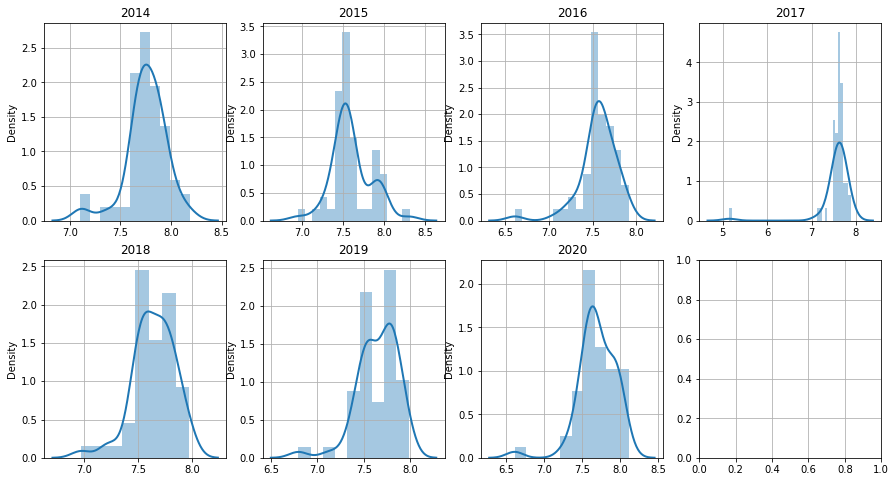

In [ ]:
# filtering date 1년 단위로 슬라이싱
def filtering_date(data, date1, date2):
    if date1 is not str:
        date1 = str(date1)
    
    if date2 is not str:
        date2 = str(date2)
        
    if isinstance(data, pd.DataFrame) == False:
        data = pd.DataFrame(data)
        
    data = data[(data.index >= date1) & (data.index <= date2)]
    return data

f, axes = plt.subplots(2, 4, figsize=(15, 8))
sns.distplot(filtering_date(np.log(df1.seoul), "2014-01-01", "2014-12-31"), ax = axes[0, 0]).set(title = "2014")
sns.distplot(filtering_date(np.log(df1.seoul), "2015-01-01", "2015-12-31"), ax = axes[0, 1]).set(title = "2015")
sns.distplot(filtering_date(np.log(df1.seoul), "2016-01-01", "2016-12-31"), ax = axes[0, 2]).set(title = "2016")
sns.distplot(filtering_date(np.log(df1.seoul), "2017-01-01", "2017-12-31"), ax = axes[0, 3]).set(title = "2017")
sns.distplot(filtering_date(np.log(df1.seoul), "2018-01-01", "2018-12-31"), ax = axes[1, 0]).set(title = "2018")
sns.distplot(filtering_date(np.log(df2.seoul), "2019-01-01", "2019-12-31"), ax = axes[1, 1]).set(title = "2019")
sns.distplot(filtering_date(np.log(df2.seoul), "2020-01-01", "2020-12-31"), ax = axes[1, 2]).set(title = "2020")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



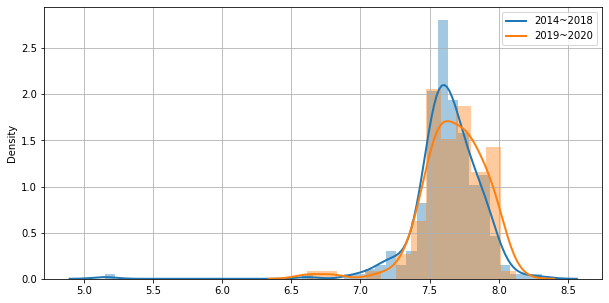

In [ ]:
# 2014~2018년과 2019~2020년 비교
f1, axe = plt.subplots(1, figsize=(10,5))
sns.distplot(filtering_date(np.log(df1.seoul), "2014-01-05", "2018-12-30"))
sns.distplot(filtering_date(np.log(df2.seoul), "2019-01-01", "2020-12-31"))
plt.legend(labels=['2014~2018','2019~2020'])

매년 분포도는 흥미로운 특징들을 보여줍니다. 2014, 2018, 2019,2020년 분포는 거래량 분포가 비슷해 보이는데 2018, 2019, 2020년 분포도는 두개의 평균을 갖는 multimodal(다중봉우리) 분포도를 나타냅니다. 다중봉우리는 타임시리즈가 평균을 중심으로 변동할 때 발생합니다.

1차 임대차 3법 이후인 2019년 기준으로 나눈 분포도입니다. 플롯을 보면 거래량 평균이 증가한 결과를 보여준다.

2018-2019년 이전 시리즈가 근본적인 원인에 변화가 있었기 때문에 2019-2020년을 예측할 수 있는지 궁금하여 그레인저-인과관계 테스트를 진행하려고 합니다.

In [ ]:
# 평균과 표준편차가 시간에 따라 어떻게 변하는지.

m1 = filtering_date(df1.seoul, "2014-01-01", "2015-01-01")
m2 = filtering_date(df1.seoul, "2015-01-01", "2016-01-01")
m3 = filtering_date(df1.seoul, "2016-01-01", "2017-01-01")
m4 = filtering_date(df1.seoul, "2017-01-01", "2018-01-01")
m5 = filtering_date(df1.seoul, "2018-01-01", "2019-01-01")
m6 = filtering_date(df2.seoul, "2019-01-01", "2020-01-01")
m7 = filtering_date(df2.seoul, "2020-01-01", "2020-12-27")

def mean_sd(data):
    return print(f' Mean : {np.mean(data)}')

print(mean_sd(m1), mean_sd(m2), mean_sd(m3), mean_sd(m4), mean_sd(m5), mean_sd(m6), mean_sd(m7))

# 2016년까지 감소하다 다시 증가함.

 Mean : seoul    2380.538462
dtype: float64
 Mean : seoul    2053.884615
dtype: float64
 Mean : seoul    1966.09434
dtype: float64
 Mean : seoul    2006.339623
dtype: float64
 Mean : seoul    2121.403846
dtype: float64
 Mean : seoul    2147.384615
dtype: float64
 Mean : seoul    2262.115385
dtype: float64
None None None None None None None


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
# Taking data between 2016-01-01 and 2018-01-01
s1 = np.array(filtering_date(df1.seoul, "2017-01-01", "2018-12-31"))
s2 = np.array(df2.seoul)

# Stacking 2 series
data = np.column_stack((s1, s2))
df_ = pd.DataFrame(data, columns = {"before", "after"})

maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data = df_, variables = df_.columns, test = test, verbose = False)


'''
    시계열의 가능한 모든 조합의 Granger 인과관계를 확인.
    행은 응답 변수이고 열은 예측 변수입니다.
    p-value는 유의수준(0.05)보다 작은 p-value는 과거 값의 계수가 귀무가설 0,
    즉 x로 인해 y가 기각될 수 없습니다.
    data : 시계열 변수를 포함하는 판다스 데이터 프레임
    variables:시계열 변수의 이름을 포함하는 리스트
    """
    
# 그레인저 인과과계 결과는 임대차3법이 통과되기 전의 이전 시리즈인 2016-2018이 2019-2020데이터를 예측할 수 있다고 말한다. 
# 두 개의 시계열 데이터에서 한 변수(한 시계열)의 과거데이터와 다른 한 변수(시계열)의 과거데이터의 결합으로 그 변수(처음 시계열)를 선형 예측(linear regression)을 했을 때 다른 한 변수의 과거데이터로만 선형예측 한 것이 통계적으로 유의미하고 예측에 도움을 줬다면 그것을 그래인저 인과(Granger Causality)가 있다고말한다.


'Check Granger Causality of all possible combinations of the Time series.\n    The rows are the response variable, columns are predictors. The values in the table \n    are the P-Values. P-Values lesser than the significance level (0.05), implies \n    the Null Hypothesis that the coefficients of the corresponding past values is \n    zero, that is, the X does not cause Y can be rejected.\n\n    data      : pandas dataframe containing the time series variables\n    variables : list containing names of the time series variables.\n\n    시계열의 가능한 모든 조합의 Granger 인과관계를 확인.\n    행은 응답 변수이고 열은 예측 변수입니다.\n    p-value는 유의수준(0.05)보다 작은 p-value는 과거 값의 계수가 귀무가설 0,\n    즉 x로 인해 y가 기각될 수 없습니다.\n    data : 시계열 변수를 포함하는 판다스 데이터 프레임\n    variables:시계열 변수의 이름을 포함하는 리스트\n    '

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Nov, 2021
Time:                     05:40:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.9013
Nobs:                     256.000    HQIC:                  -11.2987
Log likelihood:           438.709    FPE:                9.48730e-06
AIC:                     -11.5660    Det(Omega_mle):     7.90963e-06
--------------------------------------------------------------------
Results for equation seoul
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.002599         0.016254            0.160           0.873
L1.seoul          -0.847283         0.162713           -5.207           0.000
L1.daejeon         0.058715         0.159459            0.368           

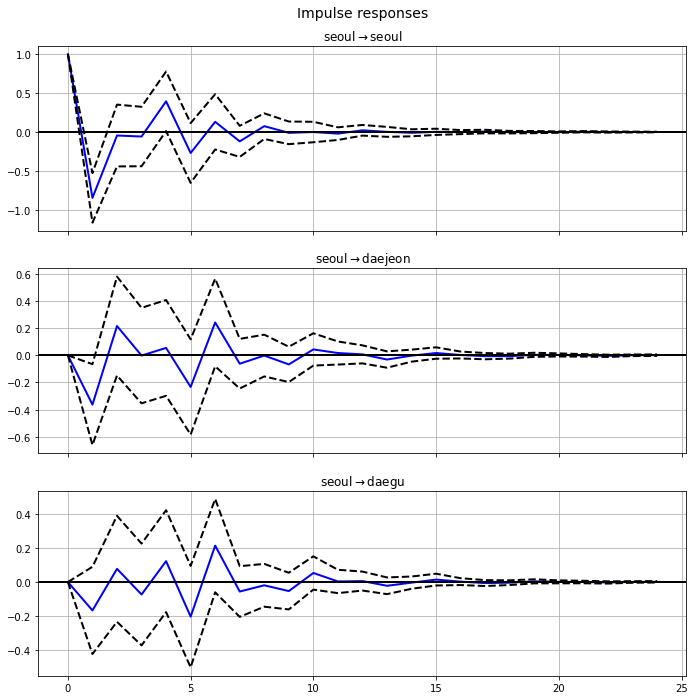

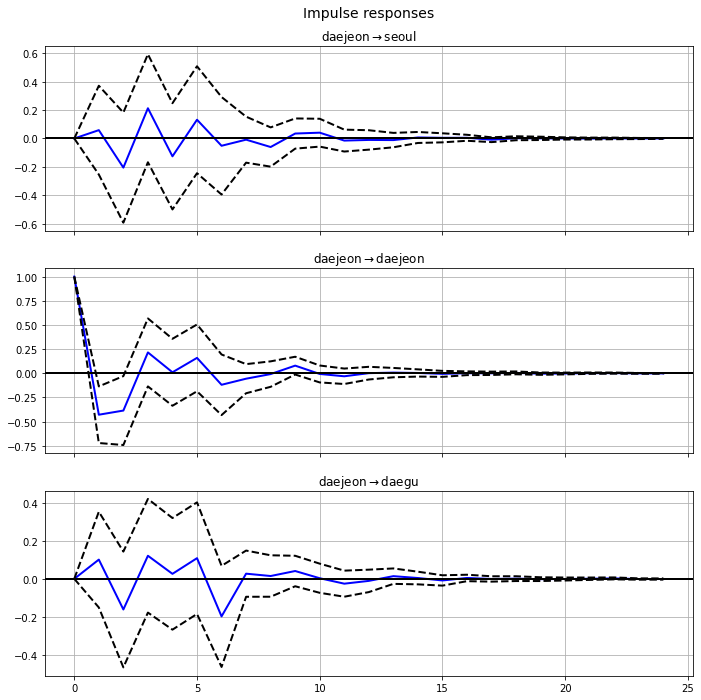

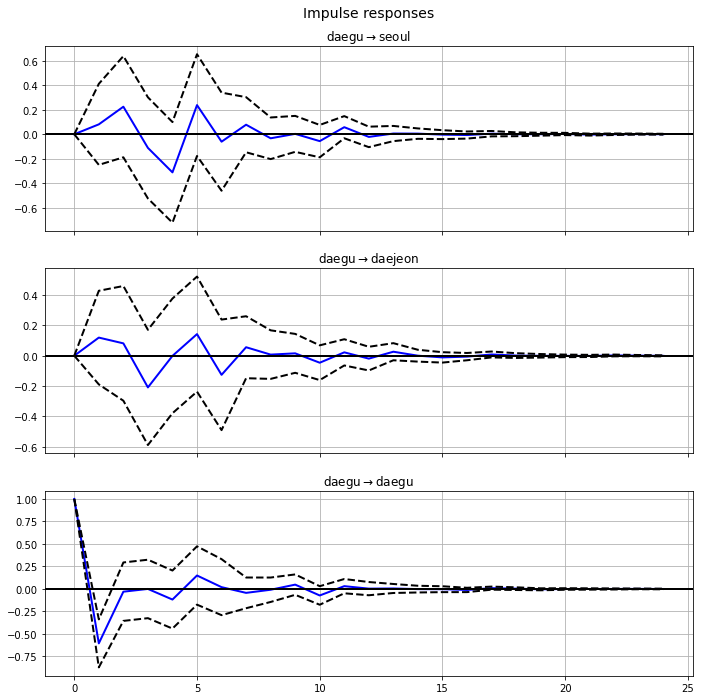

In [ ]:
# VAR modeling Vector autoregression

TimeSeries(data = np.log(df1).diff()).VAR(irf = True)
# 벡터 자기회귀는 시간이 지남에 따라 변하는 여러 수량 간의 관계를 캡처하는데 사용되는 모델.
# VAR 모델은 다변수 시계열을 허용하여 단일변수 자기회귀 모델을 일반화합니다.

VAR 모델링 후 알 수 있는 결과는 전 타임시리즈의 결과로 다음 시리즈의 거래량 증가를 유발시킬 수 있음을 알 수 있습니다. 그래서 임대차3법 통과 후 거래 증가를 확인하고 있습니다."

Text(0.5, 1.0, 'PACF Log-Seoul')

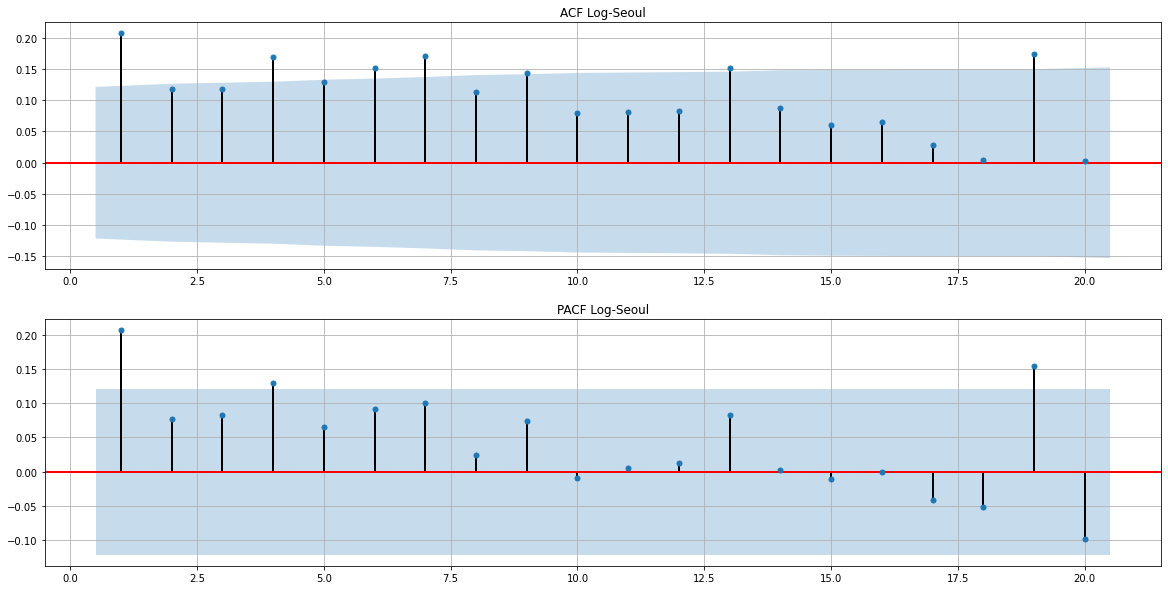

In [ ]:
'''ARIMA Modeling'''
import statsmodels.graphics.tsaplots as sgt 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(np.log(df1.seoul), lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF Log-Seoul")


sgt.plot_pacf(np.log(df1.seoul), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF Log-Seoul")
# 시즌이 안에 있다.

ACF 테스트는 문제가 될 수 있는 주기적인 컴포넌트를 보여줍니다. p와 q를 선택하기 위헤 acf, pacf 결과를 참고합니다. 다만 확신할 수 없기에 가장 높은 로그 가능성과 가장 낮은 AIC,BIC 기준을 제공하는 모델을 선택해야 합니다. 훈련셋과 테스트셋의 경우 df1을 훈련 세트로 df2로 테스트셋으로 사용하려고 합니다.

In [ ]:
!pip install arch
# !pip install statsmodels

In [1]:
# ADF 테스트 Augmented Dickey_Fuller Test(unit root test)
train_time = TimeSeries(data = pd.DataFrame(df1.seoul))

train_time.Adfuller(regression ="n") # 추세는 있고 상수항이 없다고 가정
# 결과 : Non Stationary (비고정성,비정상성)
# 정상성 판단 결과 p-value가 0.05이상이므로 귀무가설(H0)를 기각하지 못한다.
print('\n')
train_time.Adfuller(regression ="ct") # 추세랑 상수항이 둘다 존재한다고 가정
# regression='ct' 추세를 중심으로 정상성 테스트

# 시리즈 트렌드는 고정적, 타임시리즈 결정적으로 트렌드가 고정적인가?

NameError: ignored

In [ ]:
# from statsmodels.tsa.stattools import kpss
# kpss(df1.seoul, regression = 'ct')
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df1.seoul, regression='ct')

# Time Series is not deterministic trend stationary. Trend is stochastic. 시간에따라 랜덤하게 변해가는
# 1 KPSS statistics
# 2 p-value 0.05이상 Non Stationary (kpss는 반대)
# 3 lags
# 4 critical values

KPSS Statistic: 0.17869046682925008
p-value: 0.02399107493903122
num lags: 16
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'



Text(0.5, 1.0, 'PACF Log-Seoul diff')

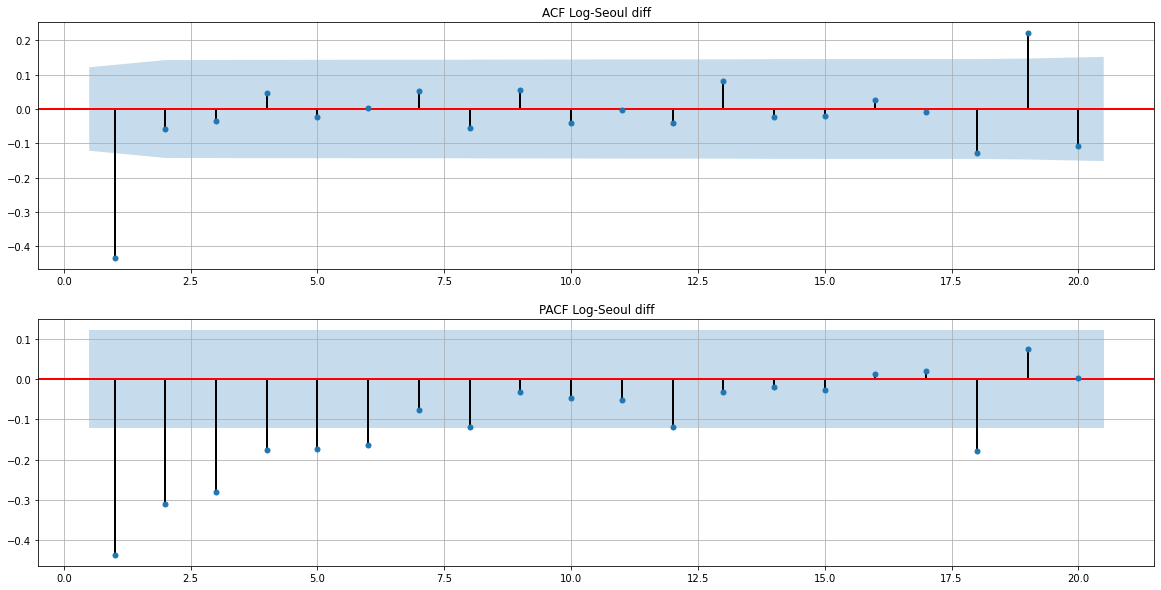

In [ ]:
# ACF, PACF check
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

df1.diff = np.log(df1.seoul).diff()
df1.diff.dropna(inplace = True)

sgt.plot_acf(df1.diff, lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF Log-Seoul diff")

sgt.plot_pacf(df1.diff, lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF Log-Seoul diff")

# 차분 이후 계절성은 사라진다.

'Trend는 보시다시피 2016년 이후로 증가하는 추세를 가지고,\n계절성도 주기적인 형태가 띄고 있습니다. Residual은 Observed에서 \n트렌드, 시즈널리티를 뺀 결과이고 트렌드, 시즈널리티, 레지듀얼을\n다 합치면 맨위 Observed 플롯이 됩니다.'

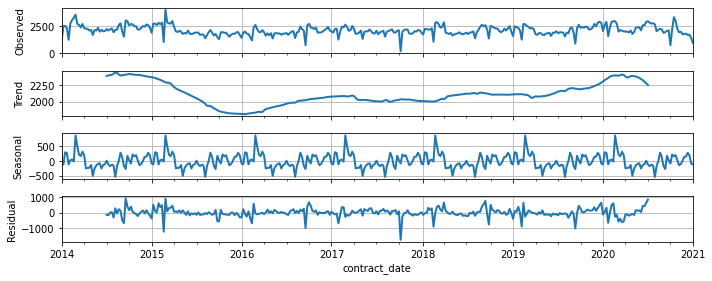

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df.csv", squeeze = True,  
                                                 index_col = "contract_date", parse_dates = [0])

seasonal_diff = np.log(seasonal).diff() # 로그차분
seasonal_diff.dropna(inplace = True)

result = seasonal_decompose(seasonal.seoul, model = "additive")
result.plot()
# 다음 결과는 trend, seasonality, residual 을 뽑아낸 결과이다.
'''Trend는 보시다시피 2016년 이후로 증가하는 추세를 가지고,
계절성도 주기적인 형태가 띄고 있습니다. Residual은 Observed에서 
트렌드, 시즈널리티를 뺀 결과이고 트렌드, 시즈널리티, 레지듀얼을
다 합치면 맨위 Observed 플롯이 됩니다.'''

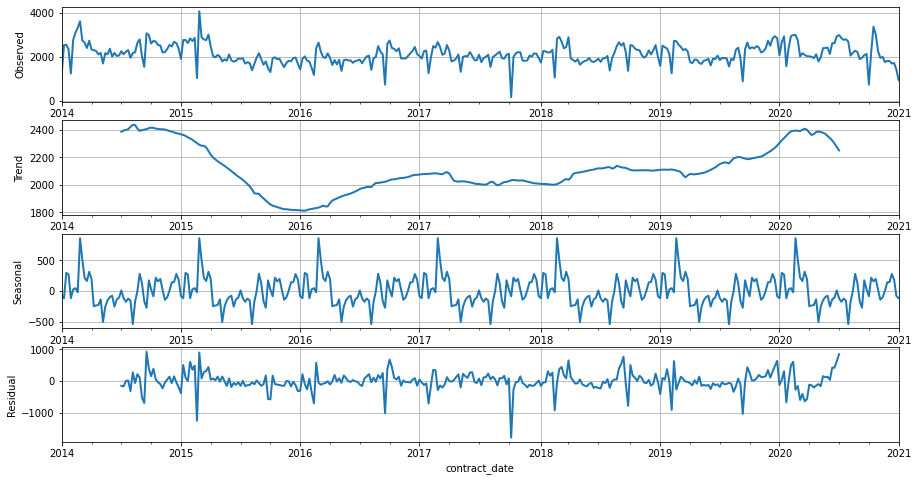

In [ ]:
def plot_decompose(decomposeresult):
  fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8))
  decomposeresult.observed.plot(ax=ax1)
  ax1.set_ylabel('Observed')
  decomposeresult.trend.plot(ax=ax2)
  ax2.set_ylabel('Trend')
  decomposeresult.seasonal.plot(ax=ax3)
  ax3.set_ylabel('Seasonal')
  decomposeresult.resid.plot(ax=ax4)
  ax4.set_ylabel('Residual')
plot_decompose(result)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  312
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2305.406
Method:                       css-mle   S.D. of innovations            390.942
Date:                Thu, 25 Nov 2021   AIC                           4618.812
Time:                        05:41:30   BIC                           4633.784
Sample:                             1   HQIC                          4624.796
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9716      4.093      0.237      0.812      -7.050       8.993
ma.L1.D.y     -0.6694      0.057    -11.740      0.000      -0.781      -0.558
ma.L2.D.y     -0.1498      0.060     -2.510      0.0

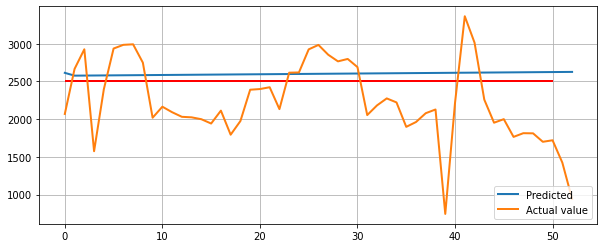

In [ ]:
# Un-conditional
from statsmodels.tsa.arima_model import ARIMA

# Spliting data, Training until 2019 testing for 2020
train = df[df.index <= "2019-12-30"]
test = df[df.index >= "2019-12-30"].seoul.values

# Model fitting 
model = ARIMA(train.seoul.values, order = (0, 1, 2))
fit = model.fit()
print(fit.summary())

# Rolling forecasting
pred = fit.forecast(test.shape[0])[0]

# Plotting
stacked = np.column_stack((pred, test))
plt.hlines(2500,0,50,color="red")
plt.plot(stacked)
plt.legend(["Predicted", "Actual value"], loc = "lower right")

# 비조건부 예측결과는 거래량이 증가함.

In [ ]:
pred

array([2613.71672852, 2576.73370941, 2577.70533328, 2578.67695716,
       2579.64858104, 2580.62020491, 2581.59182879, 2582.56345267,
       2583.53507655, 2584.50670042, 2585.4783243 , 2586.44994818,
       2587.42157205, 2588.39319593, 2589.36481981, 2590.33644369,
       2591.30806756, 2592.27969144, 2593.25131532, 2594.22293919,
       2595.19456307, 2596.16618695, 2597.13781083, 2598.1094347 ,
       2599.08105858, 2600.05268246, 2601.02430633, 2601.99593021,
       2602.96755409, 2603.93917797, 2604.91080184, 2605.88242572,
       2606.8540496 , 2607.82567347, 2608.79729735, 2609.76892123,
       2610.74054511, 2611.71216898, 2612.68379286, 2613.65541674,
       2614.62704061, 2615.59866449, 2616.57028837, 2617.54191225,
       2618.51353612, 2619.48516   , 2620.45678388, 2621.42840776,
       2622.40003163, 2623.37165551, 2624.34327939, 2625.31490326,
       2626.28652714])

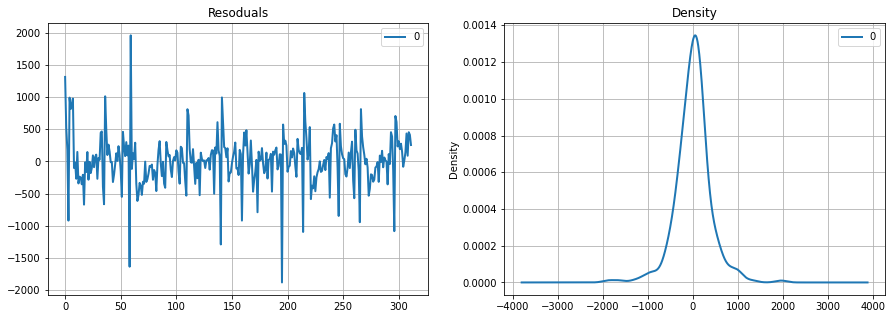

In [ ]:
# plot reisdual errors
residuals = pd.DataFrame(fit.resid)
fig , ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title='Resoduals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
# 패턴이 없는지 확인하기 위해 잔차를 플롯, (즉, 일정한 평균과 분산을 찾습니다.)

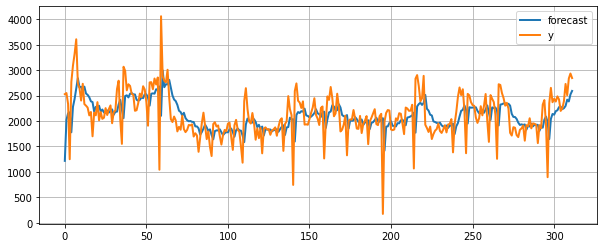

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

# Actual vs Fitted
fit.plot_predict(dynamic=False) # dynamic=False 샘플 내 지연 값을 설정하면 예측에 사용
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(pred, test)

{'corr': -0.391701653469376,
 'mae': 528.929129611745,
 'mape': 0.3079779586106679,
 'me': 364.51401657992665,
 'minmax': 0.19888755691344628,
 'mpe': 0.2528012076045075,
 'rmse': 637.7741598624483}

In [2]:
'''Prophet model'''
from fbprophet import Prophet

'''프로펫은 시계열 데이터를 예측하는 가법모형 모델입니다. additive에 기반을 둔 비선형 모델이고
    년도별,주별, 일별 계절성 그리고 휴일 효과도 가지고 있습니다.
    프로펫은 타임시리즈를 예측할때 가장 강력하고, 계절성과 몇몇 과거 데이터를 사용합니다.
    프로펫은 누락된 데이터와 변화에 강하고 일반적으로 이상값을 잘 처리합니다. '''

'''

- 프로펫은 시계열 데이터를 트렌드, 계절성, 휴일로 분해합니다.
- 트렌드는 시계열 데이터의 비주기적인 변화를 모델링합니다.
- 계절성은 일별, 주별, 연도별 계절성과 같은 주기적인 변화로 인해 발생합니다.
- 휴일은 하루 또는 며칠 동안 불규칙적인 일이 발생한 휴일입니다.
- 오차항은 프로펫 모형에서 설명하지 않습니다.

'''

'\n\n- 프로펫은 시계열 데이터를 트렌드, 계절성, 휴일로 분해합니다.\n- 트렌드는 시계열 데이터의 비주기적인 변화를 모델링합니다.\n- 계절성은 일별, 주별, 연도별 계절성과 같은 주기적인 변화로 인해 발생합니다.\n- 휴일은 하루 또는 며칠 동안 불규칙적인 일이 발생한 휴일입니다.\n- 오차항은 프로펫 모형에서 설명하지 않습니다.\n\n'

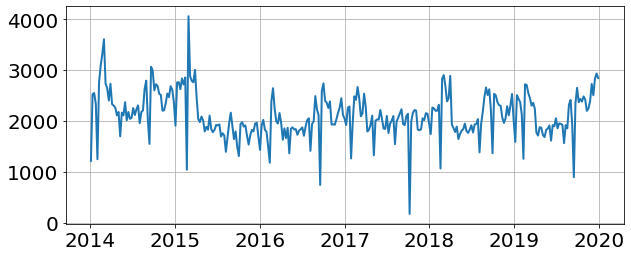

In [ ]:
# Creating "ds" and "y"
index = pd.to_datetime(train.index)
training = np.array(train.seoul, dtype = np.float32)
X_train = pd.DataFrame(training, index = index, columns = ["y"])
X_train["ds"] = X_train.index
X_train["ds"] = pd.to_datetime(X_train["ds"])

# Ploting 
plt.plot(X_train.y)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'A variation in values from the output presented \n    is to be expected as Prophet relies on Markov chain Monte Carlo \n    (MCMC) methods to generate its forecasts.\n\n    출력값의 변화는 프로펫의 mcmc 방법에 의해서 예측이 일어난다.\n'

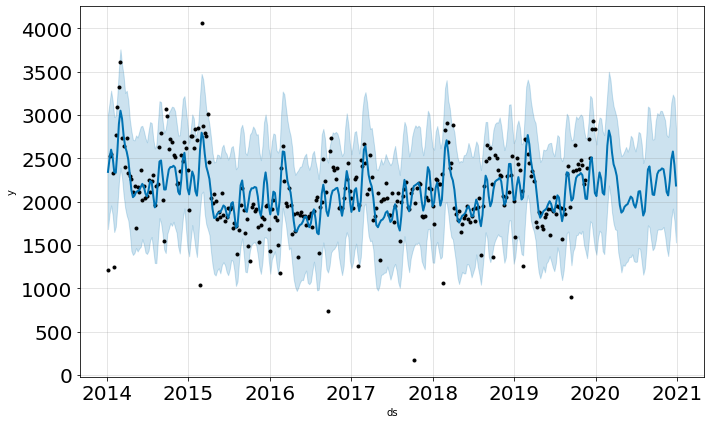

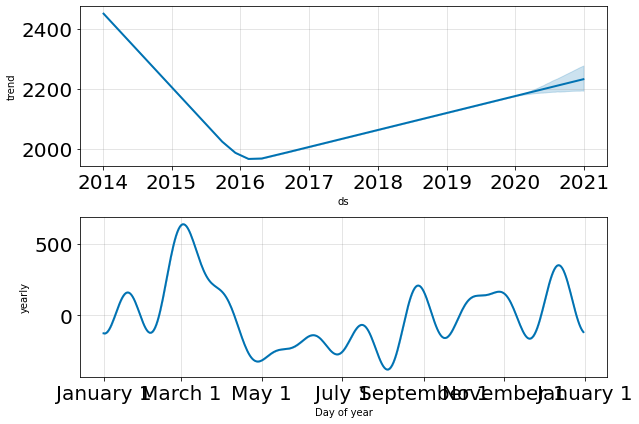

In [ ]:
# 트렌드의 불확실성 수준을 0.95로 설정, 디폴트값 80%
from fbprophet import Prophet
model = Prophet(interval_width = 0.95)
model.fit(X_train)

# Making "ds dataframe for forecasting"
reference_date = "2019-12-30"
fore = model.make_future_dataframe(periods = 52, freq='W')

# Forecasting 
fore = model.predict(fore)
fore[["ds", "yhat", "yhat_lower", "yhat_upper"]]

# Ploting result 
model.plot(fore, uncertainty=True)

model.plot_components(fore)
'''
    ds: the datestamp of the forecasted value
    yhat: the forecasted value of our metric 
    yhat_lower: the lower bound of our forecasts
    yhat_upper: the upper bound of our forecasts
'''

'''A variation in values from the output presented 
    is to be expected as Prophet relies on Markov chain Monte Carlo 
    (MCMC) methods to generate its forecasts.

    출력값의 변화는 프로펫의 mcmc 방법에 의해서 예측이 일어난다.
    mcmc 찾아보기, 프로펫은 내부적 구조는 복잡함.
'''

In [ ]:
fore[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2014-01-05,2158.044739,1518.528439,2780.897020
1,2014-01-12,2335.931797,1741.045237,2954.312782
2,2014-01-19,2456.878435,1836.358172,3081.162691
3,2014-01-26,2376.976830,1743.457942,2959.931581
4,2014-02-02,2213.960603,1610.036446,2809.368329
...,...,...,...,...
360,2020-11-29,2412.964744,1305.764622,3482.306590
361,2020-12-06,2656.203618,1545.027179,3767.993051
362,2020-12-13,2741.908406,1554.528694,3936.817188
363,2020-12-20,2585.212221,1429.907467,3784.790927


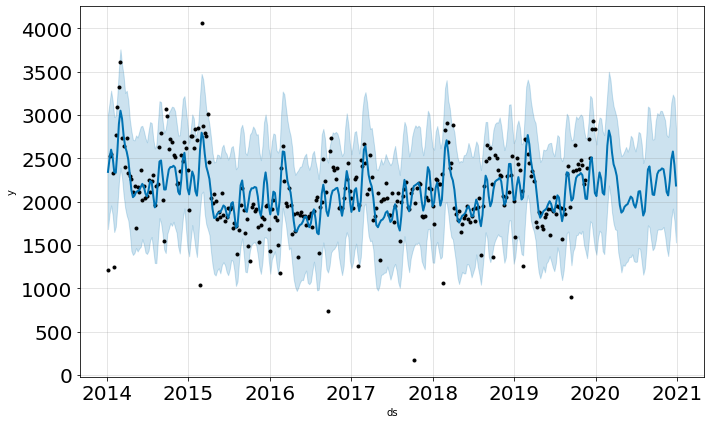

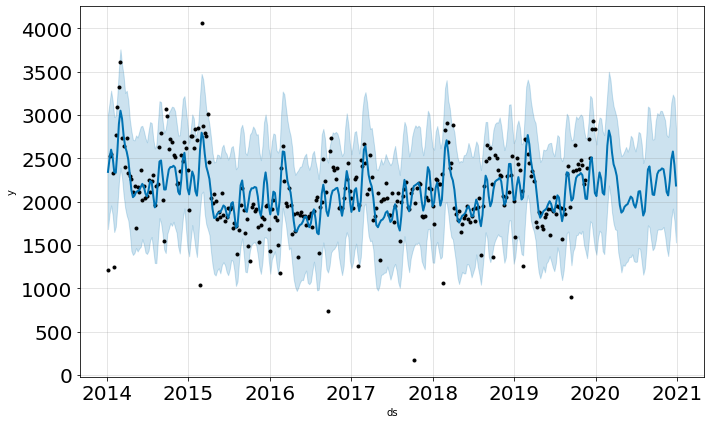

In [ ]:
# Ploting result 
model.plot(fore, uncertainty=True)

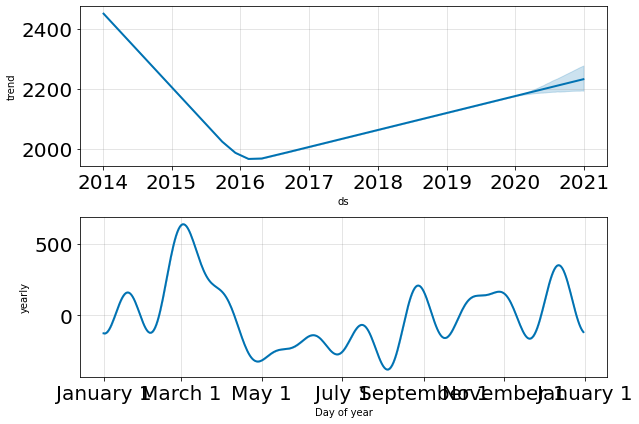

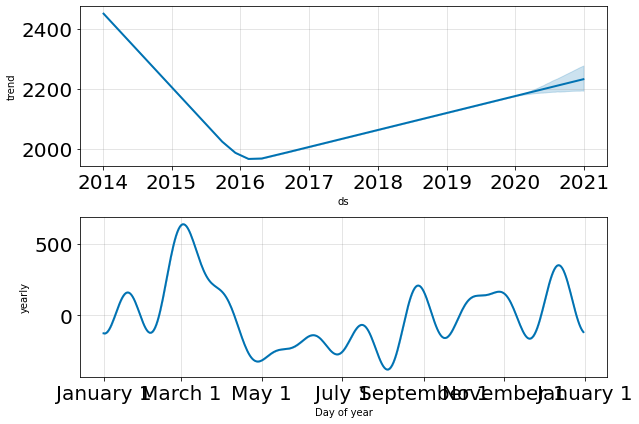

In [ ]:
model.plot_components(fore)

프로펫 모델의 위클리 트렌드는 2016년에 가장 낮은 수준에 도달했고, 이 트렌드는 2016년 이후 지속적으로 상승하는 추세를 보여준다. 2019년 7월 임대차3법이 통과된 이후로 2017년에 계약한 사람들이 계약을 연장하여 거래건수 증가할 것을 예상합니다.

hp 필터가 보여준것처럼 2016년 1분기 부터 트렌드가 바뀌었습니다.( 집값 상승과 관련이 있지 않을까? 집값이 오르면 전세 구하기가 더 어려울 것이라 예상하기 때문)
이 사실은 벡터자기회귀모델과 hp필터의 임펄스 응답 기능을 통해 확인했습니다.

두번째 플롯은, 거래량이 해당 그림에 도달한 시점에 대한 정보를 나타냅니다.
yearly 플롯은 사이클과, 트렌드,확률적 구성요소를 제외하고 봄과 겨울에 거래량이 높았던 것을 보여주고 있고, 이 결과로 아마도 과거 값이 영향을 받았을 것입니다.

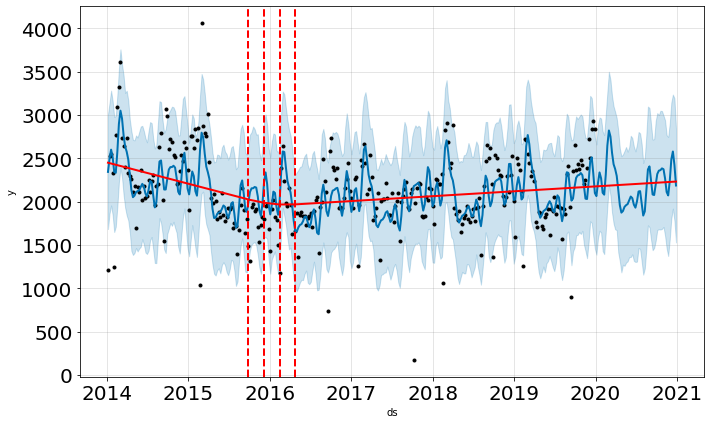

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(fore)
a = add_changepoints_to_plot(fig.gca(), model, fore)

프로펫 모델 예측은 거래량의 상승 추세를 나타냅니다.

In [ ]:
df.seoul

contract_date
2014-01-05    1215
2014-01-12    2527
2014-01-19    2549
2014-01-26    2335
2014-02-02    1248
              ... 
2020-12-06    1812
2020-12-13    1700
2020-12-20    1720
2020-12-27    1424
2021-01-03     943
Name: seoul, Length: 366, dtype: int64

In [ ]:
fore

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-05,2232.784893,1518.528439,2780.897020,2232.784893,2232.784893,-74.740154,-74.740154,-74.740154,-74.740154,-74.740154,-74.740154,0.0,0.0,0.0,2158.044739
1,2014-01-12,2247.322948,1741.045237,2954.312782,2247.322948,2247.322948,88.608849,88.608849,88.608849,88.608849,88.608849,88.608849,0.0,0.0,0.0,2335.931797
2,2014-01-19,2261.861003,1836.358172,3081.162691,2261.861003,2261.861003,195.017432,195.017432,195.017432,195.017432,195.017432,195.017432,0.0,0.0,0.0,2456.878435
3,2014-01-26,2276.399058,1743.457942,2959.931581,2276.399058,2276.399058,100.577772,100.577772,100.577772,100.577772,100.577772,100.577772,0.0,0.0,0.0,2376.976830
4,2014-02-02,2290.937113,1610.036446,2809.368329,2290.937113,2290.937113,-76.976510,-76.976510,-76.976510,-76.976510,-76.976510,-76.976510,0.0,0.0,0.0,2213.960603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-11-29,2375.769795,1305.764622,3482.306590,1438.560966,3300.223906,37.194950,37.194950,37.194950,37.194950,37.194950,37.194950,0.0,0.0,0.0,2412.964744
361,2020-12-06,2378.450442,1545.027179,3767.993051,1411.825648,3322.906100,277.753177,277.753177,277.753177,277.753177,277.753177,277.753177,0.0,0.0,0.0,2656.203618
362,2020-12-13,2381.131089,1554.528694,3936.817188,1387.397683,3340.971590,360.777317,360.777317,360.777317,360.777317,360.777317,360.777317,0.0,0.0,0.0,2741.908406
363,2020-12-20,2383.811736,1429.907467,3784.790927,1361.837723,3370.649160,201.400485,201.400485,201.400485,201.400485,201.400485,201.400485,0.0,0.0,0.0,2585.212221


In [ ]:
ac = np.array(df.seoul.values)[:365]
fc = np.array(fore.yhat)

In [ ]:
ac.shape

(365,)

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})


forecast_accuracy(fc, ac)

{'corr': 0.5364849664823998,
 'mae': 259.78877004151735,
 'mape': 0.16507381786468575,
 'me': -8.508370606273605,
 'minmax': 0.11021879116455591,
 'mpe': 0.06078691356955496,
 'rmse': 379.65590730572967}

#######################################################################################################
LSTM (DNN RNN 먼저)
#######################################################################################################

In [ ]:
''' Long short term Memory (LSTM) using same Training and Test sets.
    LSTM classification problem '''
import tensorflow as tf

# Spliting datasets 
''' series is converted into binary variable if
    present value is bigger than previous value, its value is assgied as 1, 
    No changes assigned as 0 
    present value is smaller than previous value, assigning 0 '''

# Taking date
date = X_train.ds
X_train["changes"] = np.log(X_train["y"]).diff() 

# Omitting first variable on y
X_train.dropna(inplace = True)

# Converting as binary variable 

def binary_converter(data):
    if isinstance(data, pd.DataFrame) == True:
        data = data.values
        
    x = list()
    for i in range(len(data)):
        if data[i] > 0:
            x.append(1)
        else:
            x.append(0)
    return x

# Spliting for epochs

def dataset_split(X_train, y_train, window_size):
    X = list()
    y = list()
    
    if isinstance(X_train, pd.DataFrame) == True:
        X_train = X_train.values
        
    if isinstance(y_train, pd.DataFrame) == True:
        y_train = y_train.values
        
    for i in range(len(X_train) - window_size - 1):
        X_ = X_train[i : i + window_size]
        y_ = y_train[i + window_size]
        X.append(X_)
        y.append(y_)
    return np.array(X), np.array(y)

def Single_Datasplit(data, window_size):
    X = list()
    
    if isinstance(data, pd.DataFrame) == True:
        data = data.values
  
    for i in range(len(data) - window_size - 1):
        X_ = data[i : i + window_size]
        X.append(X_)
    return np.array(X)

X_train_set = X_train.get("y").values
y_train_set = np.array(binary_converter(X_train.get("changes")), dtype = np.float32)

# Data split with moving windows = 12 (three Month)

x_train_, y_train_ = dataset_split(X_train = X_train_set, 
                                  y_train = y_train_set, 
                                  window_size = 12)

X_test_ = Single_Datasplit(test, window_size = 12)
x_test__ = X_test_.reshape(X_test_.shape[0], 1, X_test_.shape[1])

print(x_train_.shape, y_train_.shape)

In [ ]:
# Model construction with dropout of 0.5 
# reshape to (batch, )

x_train_input = x_train_.reshape(x_train_.shape[0], 1, x_train_.shape[1])

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(250, activation = "relu", 
                         return_sequences= True, input_shape = (x_train_input.shape[1], x_train_input.shape[2])),
    tf.keras.layers.Dense(150, activation = "relu"),
    tf.keras.layers.Dropout((0.5)),
    tf.keras.layers.Dense(150, activation = "sigmoid"),
    tf.keras.layers.Dense(1)
    ])

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=["accuracy", "binary_accuracy"])
history = model.fit(x_train_input, y_train_, epochs = 200, validation_split = 0.2, shuffle = False)

'''Binary Classification dose not give a good accuracy. '''

In [ ]:
'''LSTM Regression problem '''

def regression_dataset(data, windows):
    x, y = list(), list()
    for i in range(len(data) - windows - 1):
        a = data[i : (i + windows)]
        x.append(a)
        y.append(data[i + windows])
    return np.array(x), np.array(y)

regression_x_train, regression_x_test = regression_dataset(np.array(X_train.y), windows = 12)

# Reshaping

regression_x_train = regression_x_train.reshape(regression_x_train.shape[0], 1, regression_x_train.shape[1])

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(250, activation = "relu", 
                         return_sequences= True, input_shape = (regression_x_train.shape[1], regression_x_train.shape[2])),
    tf.keras.layers.Dense(150, activation = "relu"),
    tf.keras.layers.Dropout((0.5)),
    tf.keras.layers.Dense(150, activation = "relu"),
    tf.keras.layers.Dense(1)
    ])

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(regression_x_train, regression_x_test, epochs = 500, validation_split = 0.2, shuffle = False)

NameError: ignored